# Condensation Runnables

(Work in progress, probably split into multiple notebooks)

Condensation, is the first process where this framework we have been building up is applied. Here we need to account for the gas phase, and the particle phase. Then ensure that the partial pressures of species at the surface of the particle are equal to the partial pressure in the gas.


### Core Concepts:

- **Runnable**: An abstract base class defining the interface for aerosol transformation processes.
  - Here and aerosol object is passed to the process, and the process is expected to modify the aerosol object in place, returning the modified object.
- **MassCondensation**: A concrete class implementing the RunnableProcess interface for the condensation process. Is an implementation of a `Runnable` process that adds mass to the aerosol object based on the partial pressures of the gas phase and the particle phase. Then removes the mass from the gas phase.

### Inputs:

The inputs get a bit complicated here, but in the future we will build factories to handle the creation of these objects and use builder patterns to change units and verify inputs. For now, we will just create them manually.


In [9]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next.gas_species import GasSpeciesBuilder
from particula.next.gas import GasBuilder
from particula.next.particle import Particle, particle_strategy_factory
from particula.next.aerosol import Aerosol
from particula.next.gas_vapor_pressure import vapor_pressure_factory
from particula.next.particle_activity import particle_activity_strategy_factory
from particula.next.surface import surface_strategy_factory
from particula.next.particle_process import MassCondensation
from particula.next.condensation import CondensationIsothermal

In [10]:
# Create a Gas instance
# Define the coefficients for Butanol using the Antoine equation.
butanol_coefficients = {
    'latent_heat': 267.0e3,  # check these values, they seem too high, or what latent heat should be used is wrong.
    'temperature_initial': 298.15,
    'pressure_initial': 0.58 * 1e3}
butanol_clausius = vapor_pressure_factory(
    strategy='clausius_clapeyron', **butanol_coefficients)
styrene_coefficients = {
    'latent_heat': 42e3,
    'temperature_initial': 298.15,
    'pressure_initial': 667}
styrene_clausius = vapor_pressure_factory(
    strategy='clausius_clapeyron', **styrene_coefficients)
water_buck = vapor_pressure_factory(
    strategy='water_buck')

# set RH at 50%
water_concentration = water_buck.saturation_concentration(0.017, 298.15)*0.5

# gas species
molar_mass = np.array([0.018, 0.074121, 104.15e-3])
vapor_pressure = [water_buck, butanol_clausius, styrene_clausius]
concentration = np.array([water_concentration, 2e-6, 1e-6])
names = np.array(["water", "butanol", "styrene"])
gas_species = GasSpeciesBuilder() \
    .name(names) \
    .molar_mass(molar_mass) \
    .vapor_pressure_strategy(vapor_pressure) \
    .condensable(True) \
    .concentration(concentration) \
    .build()

# create gas
gas = GasBuilder() \
    .add_species(gas_species) \
    .temperature(298.15) \
    .total_pressure(1e5) \
    .build()

# Accessing dynamically attached methods and properties
# Example method call, assuming such a method exists
print(f"Gas species: {gas_species}")
print(gas)

Gas species: ['water' 'butanol' 'styrene']
Gas mixture at 298.15 K and 100000.0 Pa consisting of ["['water' 'butanol' 'styrene']"]


In [11]:
# particle distribution speciated mass, single mode
particle_masses = np.array([1e-22, 4.1e-20, 4.1e-20])  # kg
particle_density = np.array([1.0e3, 1.4e3, 1.4e3])  # kg/m^3
particle_concentration = np.ones_like(particle_masses) * 1e12

# particle activity strategy, or how to treat the mixing of species, kappa, ideal mixing, etc.
particle_activity_kwargs = {
    'kappa': np.array([0.0, 0.2, 0.1]),
    'molar_mass': molar_mass,
    'density': particle_density}
particle_activity = particle_activity_strategy_factory(
    strategy='kappa', **particle_activity_kwargs)

# particle surface strategy, or how to treat the surface properties, surface tension mixing rule, and Kelvin effect
particle_surface_kwargs = {
    'surface_tension': np.array([0.07, 0.03, 0.03]),
    'density': particle_density}
particle_surface = surface_strategy_factory(
    strategy_type='volume', **particle_surface_kwargs)

particle = Particle(
    strategy=particle_strategy_factory("speciated_mass_moving_bin"),
    activity=particle_activity,
    surface=particle_surface,
    distribution=particle_masses,
    density=particle_density,
    concentration=particle_concentration
)

# Particle,
print(f"Particle speciated mass [kg]: {particle.get_mass()}")
print(f"Particle radius [m]: {particle.get_radius()}")
print(f"Particle Total Mass [kg/m3]: {particle.get_total_mass()}")

Particle speciated mass [kg]: [1.0e-22 4.1e-20 4.1e-20]
Particle radius [m]: 2.4105307975606148e-08
Particle Total Mass [kg/m3]: 8.21e-08


## Condensation Equations (Isothermal)

With the gas phase and particle phase defined, we can start the condensation process. Excluding the latent heat of vaporization for the gas-particle phase transition, which is important in cloud droplet formation.

This follows Chapter 2 (EQ 2.41) by Topping, D., & Bane, M. (2022). Introduction to Aerosol Modelling (D. Topping & M. Bane, Eds.). Wiley. https://doi.org/10.1002/9781119625728. Also Chapter 12 and 13 (EQ 13.3) of Seinfeld, J. H., & Pandis, S. N. (2016). Atmospheric Chemistry and Physics: From Air Pollution to Climate Change (3rd ed.). Wiley.

The isothermal condensation or evaporation process is defined by the following equation:

$$
\frac{dm_{i}}{dt} = N \frac{k_{cond} (p_{i, gas} - p_{i, particle~surface})}{RT/ molar~mass_{i}}
$$

Where:
- $m_{i}$ is the mass of species $i$ in the particle phase, of a specific bin
- N is the number of particles
- k_{cond} is the per-particle for order condensation coefficient
- p_{i, gas} is the partial pressure of species $i$ in the gas phase
- p_{i, particle~surface} is the partial pressure of species $i$ at the surface of the particle, acounting for Kelvin effect and activity coefficients.
- R is the ideal gas constant
- T is the temperature
- molar mass_{i} is the molar mass of species $i$
- $dm_{i}/dt$ is the rate of change of mass of species $i$ in the particle phase

The first order condensation coefficient is defined as:

$$
k_{cond} = 4 \pi~radius_{particle}~D_{i}~f(Kn, \alpha)
$$

Where:
- $radius_{particle}$ is the radius of the particle
- $D_{i}$ is the vapor diffusion coefficient of species $i$
- $f(Kn, \alpha)$ is the correction factor for the molecular regime to continuum regime transition. This is a function of the Knudsen number and the accommodation coefficient.

The correction factor is defined as:

$$
f(Kn, \alpha_{i, accom.}) = \frac{0.75 \alpha_{i, accom.} (1 + Kn)}{
    (Kn^2 + Kn) + 0.283 \alpha_{i, accom.} Kn + 0.75 \alpha_{i, accom.}}
$$

Where:
- $\alpha_{i, accom.}$ is the accommodation coefficient of species $i$
- Kn is the Knudsen number
- $Kn = \frac{\lambda_{i}}{radius_{particle}}$
  - $\lambda$ is the mean free path of the gas molecules of species $i$
  - $radius$ is the radius of the particle


### Partial Pressures

The partial pressures of species $i$ in the gas phase and at the surface of the particle are defined as:

$$
p_{i, gas} = conc_{i, gas} RT/molar~mass_{i}
$$

Where:
- $conc_{i, gas}$ is the concentration of species $i$ in the gas phase

At the surface of the particle, the partial pressure is defined as:

$$
p_{i, particle~surface} = p^{pure}_{i} \gamma_{i} x_{i} k_{i,Kelvin}
$$

Where:
- $p^{pure}_{i}$ is the saturation vapor pressure of species $i$, sometimes called $p^{sat}_{i}$, $p^{vap}_{i}$, or $p^{0}_{i}$
- $\gamma_{i}$ is the activity coefficient of species $i$
- $x_{i}$ is the mole fraction of species $i$ in the particle phase
- $k_{i,Kelvin}$ is the Kelvin effect correction factor
  - $k_{i,Kelvin} = exp(k_{i, Kelvin~radius}/radius_{particle})$
  - $k_{i, Kelvin~radius} = 2 \sigma_{surface}~molar~mass_{i} / (R  T ~ density)$
    - $\sigma_{surface}$ is the effective surface tension of the particle.
    - $density$ is the effective density of the particle.


## Condensation Process (Isothermal)

In code this process is implemented as a `Runnable` process. This means that the process is expected to modify the aerosol object in place, returning the modified aerosol object. This is defined in `Particle_processes.py` as the `MassCondensation` class.

The `MassCondensation` class takes a `CondensationStrategy` object as an input. This object defines and evaluates the $dm_{i}/dt$ equation for the condensation process. More strategies can be added into the `condensation.py` file.

For now, let's just implement the isothermal condensation process, and loop over for 10 minutes. Saving the particle composition and size at each time step.

[ 1.25265990e-06 -1.88631750e-06 -3.52251079e-06]


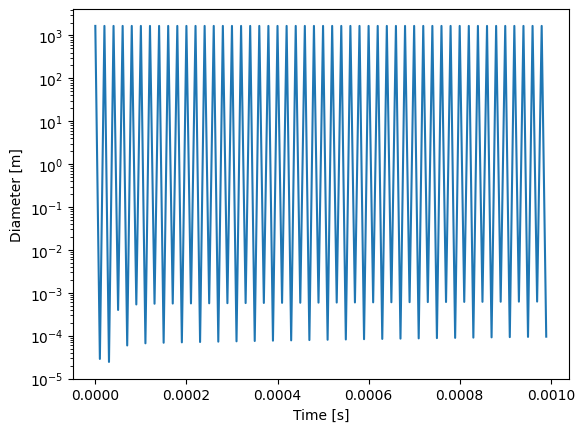

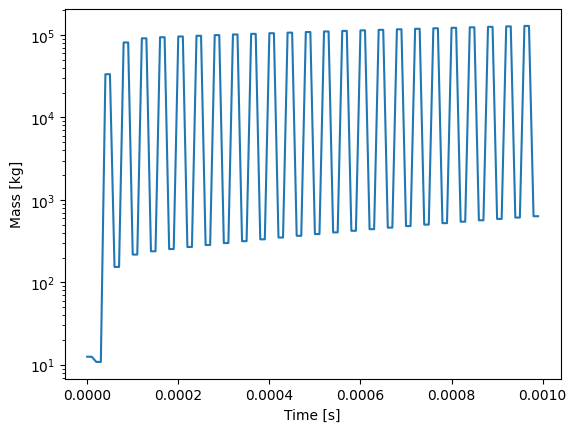

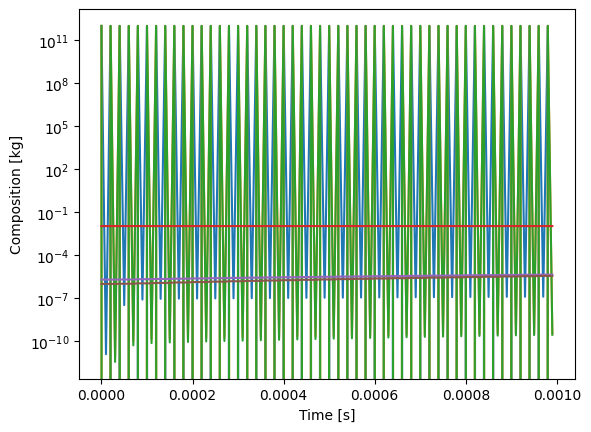

In [12]:
# define the condensation process
condensation_isothermal = CondensationIsothermal(
    molar_mass=molar_mass,
    diffusion_coefficient=2.0*1e-9,
    accommodation_coefficient=1.0,
)
condensation_process = MassCondensation(condensation_strategy=condensation_isothermal)

# define the aerosol
aerosol_single_mode = Aerosol(
    gas=copy(gas),
    particles=copy(particle))  # maybe think about particles vs particle for this name

# define the time array in seconds
time_step = 0.00001
time_array = np.arange(0, 0.001, time_step)

# output arrays
diameters = np.zeros_like(time_array)
composition = np.zeros((len(time_array), 3))
gas_composition = np.zeros((len(time_array), 3))
mass = np.zeros_like(time_array)

rate = condensation_process.rate(aerosol_single_mode)
print(rate)
# loop over time
for i, t in enumerate(time_array):

    # calculate the condensation
    aerosol_single_mode = condensation_process.execute(aerosol_single_mode, time_step)

    # save the aerosol properties
    diameters[i] = aerosol_single_mode.particles[0].get_radius()*2
    composition[i, :] = aerosol_single_mode.particles[0].get_mass()
    gas_composition[i, :] = aerosol_single_mode.gas.species[0].get_concentration()
    mass[i] = aerosol_single_mode.particles[0].get_total_mass()

# plot the results
fig, ax = plt.subplots()
ax.plot(time_array, diameters)
ax.set_yscale("log")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Diameter [m]")
plt.show()

fig, ax = plt.subplots()
ax.plot(time_array, mass)
ax.set_yscale("log")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Mass [kg]")
plt.show()

fig, ax = plt.subplots()
ax.plot(time_array, composition)
ax.plot(time_array, gas_composition)
ax.set_yscale("log")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Composition [kg]")
plt.show()
